In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/train (1).csv
/kaggle/input/dataset/test (1).csv


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Train Data Head:
                                category                       sub_category  \
0  Online and Social Media Related Crime  Cyber Bullying  Stalking  Sexting   
1                 Online Financial Fraud                  Fraud CallVishing   
2               Online Gambling  Betting           Online Gambling  Betting   
3  Online and Social Media Related Crime                   Online Job Fraud   
4                 Online Financial Fraud                  Fraud CallVishing   

                                  crimeaditionalinfo  
0  I had continue received random calls and abusi...  
1  The above fraudster is continuously messaging ...  
2  He is acting like a police and demanding for m...  
3  In apna Job I have applied for job interview 

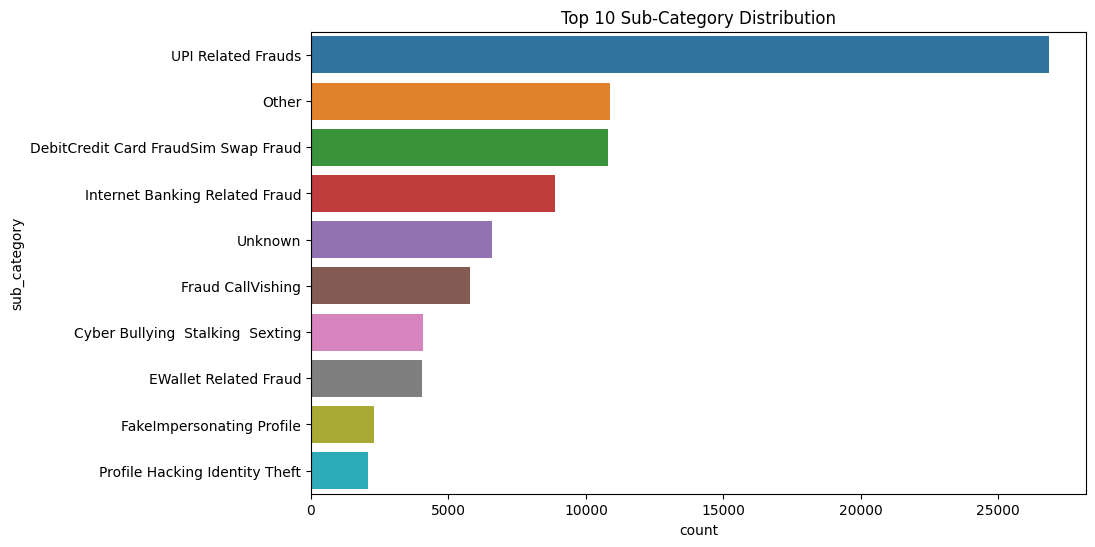

In [16]:

import pandas as pd
import re
import nltk
import joblib
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import ADASYN
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
nltk.download('stopwords')
nltk.download('punkt')

# Load Data
df = pd.read_csv('/kaggle/input/dataset/train (1).csv')
print("Train Data Head:")
print(df.head())

df = df.dropna(subset=['crimeaditionalinfo'])
df['sub_category'] = df['sub_category'].fillna('Unknown')

# Preprocess Text Data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = SnowballStemmer("english")
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['processed_text'] = df['crimeaditionalinfo'].apply(preprocess_text)

# === TF-IDF Feature Extraction ===
tfidf = TfidfVectorizer(max_features=500)
X = tfidf.fit_transform(df['processed_text']).toarray()
joblib.dump(tfidf, 'tfidf_subcategory.pkl')

# Encode Target Variable
y = df['sub_category']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, 'label_encoder_subcategory.pkl')

if y.value_counts().min() > 1:
    balancer = ADASYN(random_state=42, n_neighbors=min(5, y.value_counts().min() - 1))
    X_balanced, y_balanced = balancer.fit_resample(X, y_encoded)
else:
    X_balanced, y_balanced = X, y_encoded

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_model.fit(X_balanced, y_balanced)
joblib.dump(xgb_model, 'xgb_subcategory_model.pkl')

# Evaluate Model
y_pred = xgb_model.predict(X)
print("\nModel Accuracy:", accuracy_score(y_encoded, y_pred))
print("\nClassification Report:\n", classification_report(y_encoded, y_pred, target_names=label_encoder.classes_))

# === Visualization ===
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='sub_category', order=df['sub_category'].value_counts().index[:10])
plt.title('Top 10 Sub-Category Distribution')
plt.show()
